# COVID 19 PySpark Latent Dirchlet Allocation 
## Objective
This notebook is to document the task of extracting topics from COVID19 Related Papers from the CORD-19 Dataset. This topic distribution will be used to help with extraction of similar papers that can help researchers conduct literature review and facilitate the processs of scientific research.

It is better to run this notebook on Kaggle as you will not have to download the dataset on your local computer.

In [2]:
# install relevant libraries
!pip install langdetect
!pip install pyspark
!pip install sparknlp

In [23]:
import os
import glob
from time import time
from tqdm import tqdm

import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import pyLDAvis
from IPython.display import FileLink

from nltk.corpus import stopwords
from langdetect import detect

import warnings
warnings.filterwarnings("ignore")

In [51]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover,IDF
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline

from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import *

import glob
from pathlib import Path

In [6]:
stop_words = stopwords.words('english')

In [7]:
def init_spark():

    spark = SparkSession.builder \
        .appName("Spark NLP")\
        .master("local[4]")\
        .config("spark.driver.memory","60G")\
        .config('spark.executor,memory','60G')\
        .config('spark.memory.offHeap.enabled',True)\
        .config('spark.memory.offHeap.size','100G')\
        .config("spark.kryoserializer.buffer.max", "2000M")\
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.1")\
        .getOrCreate()
    
    return spark

In [8]:
spark = init_spark()
spark

In [9]:
# do not run this if you want to conserve RAM space

root_path = Path('/kaggle/input/CORD-19-research-challenge/') # path to dataset on Kaggle
metadata_path = root_path / Path('metadata.csv') # path to metadata giving information about each paper
metadata = pd.read_csv(metadata_path, dtype={ 'pubmed_id': str, 'doi': str})
metadata.rename(columns={'source_x': 'source', 'WHO #Covidence': 'who_covidence'}, inplace=True)
print("There are ", len(metadata), " sources in the metadata file.")

metadata.head(2)

There are  529651  sources in the metadata file.


,cord_uid,sha,source,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


## Metadata Description
This metadata allows us to get information about each paper. It consists of papers from the sources given below. It also contain the doi, title, abstract and other unique identification parameters that help us identify a given paper. 

In [10]:
metadata.source.value_counts()

WHO                                    218559
Medline                                101433
Medline; PMC                            86649
PMC                                     47288
Elsevier; Medline; PMC                  42666
MedRxiv; WHO                            10334
Elsevier; PMC                            6874
ArXiv                                    6284
BioRxiv; WHO                             2411
BioRxiv                                  1427
Medline; PMC; WHO                         930
MedRxiv                                   785
MedRxiv; Medline; PMC; WHO                620
Elsevier                                  476
BioRxiv; Medline; PMC; WHO                436
MedRxiv; Medline; WHO                     349
Elsevier; Medline; PMC; WHO               305
BioRxiv; Medline; WHO                     284
Elsevier; Medline                         255
BioRxiv; MedRxiv                          248
ArXiv; Medline; PMC                       245
Medline; WHO                      

## Extraction: Reading in COVID 19 Paper Data
Below are the functions we used to extract the data from the json dataset. Due to the limitations of the system we are operating on, we cannot use the full dataset and will have to limit the papers we operate on. This project serves as a proof of concept that the tasks described below could be used for the intended aim.

**To simplify the task:**
1. We are going to only use the abstracts instead of full text of the articles.
2. We will also try and use the abstracts from the metadata itself. 
3. We will also limit the number of documents we will use. 


In [9]:
sqlContext = SQLContext(spark)

# Utility functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return None

def concatenate_text(j):
    txt_all = ""
    for a in j:
        txt_all = txt_all + " " + a['text']
    return txt_all

udf_detect_lang = udf(detect_lang)
udf_concatenate_text = udf(concatenate_text)

In [10]:
def extract_paper_data(paper_path = "../input/CORD-19-research-challenge/document_parses/pdf_json",
                    N = 1000, all_data = False):
    
    paper_jsons = []
    count = 0
    for file in os.listdir(paper_path):
        if file.endswith(".json"):
            paper_jsons.append(os.path.join(paper_path, file))
            count+=1
    
    if all_data == False:
        paper_sample = random.sample(paper_jsons, N) # randomly sample N papers from the dataframe. 
    else:
        paper_sample = paper_jsons
        
    papers = spark.read\
                .format("json")\
                .option("multiLine", "true")\
                .load(paper_sample)

    
    papers = papers.select(papers['Paper_ID'], papers['metadata']['title'], udf_concatenate_text(papers['abstract']), udf_concatenate_text(papers['body_text']))

    papers = papers.withColumnRenamed('metadata.title', 'title')\
                   .withColumnRenamed('concatenate_text(abstract)', 'abstract')\
                   .withColumnRenamed('concatenate_text(body_text)', 'body')
    
    # detect the language used in these papers
    papers = papers.withColumn('lang', udf_detect_lang(papers['body']))
    
    
    # filter out abstracts that
    papers = papers.filter(papers['lang'] == 'en').filter("abstract != ''").filter("title != ''")
    
    return papers


def extract_metadata(metadata_path = "../input/CORD-19-research-challenge/metadata.csv",
                    N = 1000, all_data = False):
    
    print("Extracting paper metadata...")
    meta_pd = pd.read_csv(metadata_path)
    meta_pd = meta_pd[~meta_pd['abstract'].isnull()]
    metadata = pandas_to_spark(meta_pd.head(N))

    print("Detecting paper language...")
    # add column to give the language of the paper
    metadata = metadata.withColumn('lang', udf_detect_lang(metadata['abstract']))

    print("Filtering by selected language...")
    # filter to keep only papers with english language
    metadata = metadata.filter(metadata['lang']=='en')

    print("Returning DataFrame...")

    return metadata

In [11]:
# example of what this looks like
N = 500

# paper_path = "../input/CORD-19-research-challenge/document_parses/pdf_json"
# paper_df = extract_paper_data(paper_path, N)

paper_df = extract_metadata(N = N)

Extracting paper metadata...
Detecting paper language...
Filtering by selected language...
Returning DataFrame...


In [12]:
print((paper_df.count(), len(paper_df.columns)))

(500, 20)


In [16]:
paper_df.columns

['cord_uid',
 'sha',
 'source_x',
 'title',
 'doi',
 'pmcid',
 'pubmed_id',
 'license',
 'abstract',
 'publish_time',
 'authors',
 'journal',
 'mag_id',
 'who_covidence_id',
 'arxiv_id',
 'pdf_json_files',
 'pmc_json_files',
 'url',
 's2_id',
 'lang']

## NLP Pipeline

In [18]:
documentAssembler = DocumentAssembler()\
                    .setInputCol('abstract')\
                    .setOutputCol('document')

tokenizer = Tokenizer()\
                    .setMinLength(4)\
                    .setInputCols(['document'])\
                    .setOutputCol('tokenized') # Identifies tokens with tokenization open standards
    
normalizer = Normalizer()\
                    .setInputCols(['tokenized'])\
                    .setOutputCol('normalized')\
                    .setLowercase(True) # Removes all dirty characters from text

lemmatizer = LemmatizerModel\
                    .pretrained()\
                    .setInputCols(['normalized'])\
                    .setOutputCol('lemmatized') # Retrieves lemmas out of words with the objective of returning a base dictionary word

stopwords_cleaner = StopWordsCleaner()\
                    .setInputCols(['lemmatized'])\
                    .setOutputCol('unigrams')\
                    .setStopWords(stop_words) # removes stopwords

ngrammer = NGramGenerator()\
                    .setInputCols(['lemmatized'])\
                    .setOutputCol('ngrams')\
                    .setN(3)\
                    .setEnableCumulative(True)\
                    .setDelimiter('_') # gets ngrams

pos_tagger = PerceptronModel\
                    .pretrained('pos_anc')\
                    .setInputCols(['document', 'lemmatized'])\
                    .setOutputCol('pos') # sets POS tag to each word

finisher = Finisher().setInputCols(['unigrams', 'ngrams', 'pos'])

pipeline = Pipeline()\
            .setStages([documentAssembler,\
                        tokenizer,\
                        normalizer,\
                        lemmatizer,\
                        stopwords_cleaner,\
                        pos_tagger,\
                        ngrammer,\
                        finisher])

fin_doc = pipeline.fit(paper_df).transform(paper_df)

fin_doc.columns

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


['cord_uid',
 'sha',
 'source_x',
 'title',
 'doi',
 'pmcid',
 'pubmed_id',
 'license',
 'abstract',
 'publish_time',
 'authors',
 'journal',
 'mag_id',
 'who_covidence_id',
 'arxiv_id',
 'pdf_json_files',
 'pmc_json_files',
 'url',
 's2_id',
 'lang',
 'finished_unigrams',
 'finished_ngrams',
 'finished_pos']

In [19]:
# initial pipeline
pos_documentAssembler = DocumentAssembler()\
                    .setInputCol('finished_pos')\
                    .setOutputCol('pos_document')

pos_tokenizer = Tokenizer()\
                    .setInputCols(['pos_document'])\
                    .setOutputCol('pos')

# create column that gets the bigram POS combination
pos_ngrammer = NGramGenerator()\
                    .setInputCols(['pos'])\
                    .setOutputCol('pos_ngrams')\
                    .setN(3)\
                    .setEnableCumulative(True)\
                    .setDelimiter('_')

pos_finisher = Finisher()\
                    .setInputCols(['pos', 'pos_ngrams'])

pos_pipeline = Pipeline()\
                    .setStages([pos_documentAssembler,\
                                pos_tokenizer,\
                                pos_ngrammer,\
                                pos_finisher])

# create a column which a collection of POS tags as they appear in the text of the abstract
udf_join_arr = udf(lambda x: ' '.join(x), StringType())
fin_doc  = fin_doc.withColumn('finished_pos', udf_join_arr(col('finished_pos')))
fin_doc = pos_pipeline.fit(fin_doc).transform(fin_doc)
fin_doc.columns

['cord_uid',
 'sha',
 'source_x',
 'title',
 'doi',
 'pmcid',
 'pubmed_id',
 'license',
 'abstract',
 'publish_time',
 'authors',
 'journal',
 'mag_id',
 'who_covidence_id',
 'arxiv_id',
 'pdf_json_files',
 'pmc_json_files',
 'url',
 's2_id',
 'lang',
 'finished_unigrams',
 'finished_ngrams',
 'finished_pos',
 'finished_pos_ngrams']

In [20]:
def filter_pos(words, pos_tags):
    res_words = []
    for word, pos in zip(words, pos_tags):
        if pos in  ['JJ', 'NN', 'NNS', 'VB', 'VBP']:
            res_words.append(word)
            
    return res_words

def filter_pos_combs(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if (len(pos.split('_')) == 2 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['JJ', 'NN', 'NNS']) \
            or (len(pos.split('_')) == 3 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                  pos.split('_')[2] in ['NN', 'NNS'])]

udf_filter_pos = udf(filter_pos, ArrayType(StringType()))
udf_filter_pos_combs = udf(filter_pos_combs, ArrayType(StringType()))

In [21]:
fin_doc = fin_doc.withColumn('filtered_unigrams', udf_filter_pos(col('finished_unigrams'), col('finished_pos')))
fin_doc = fin_doc.withColumn('filtered_ngrams', udf_filter_pos_combs(col('finished_ngrams'), col('finished_pos_ngrams')))
fin_doc = fin_doc.withColumn('final', concat(col('filtered_unigrams'), col('filtered_ngrams')))

In [22]:
TF_vectorizer = CountVectorizer(inputCol='final', outputCol='tf_features')
TF_mod = TF_vectorizer.fit(fin_doc)
TF_result = TF_mod.transform(fin_doc)

IDF_vectorizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
IDF_mod = IDF_vectorizer.fit(TF_result)
TFIDF_result = IDF_mod.transform(TF_result)

## LDA : Topic Modeling

In [25]:
log_perplexity = []
for i in tqdm(range(5,25,5)):
    num_topics = i
    max_iter = 10
    lda = LDA(k=num_topics, maxIter=max_iter, featuresCol= 'tf_idf_features')
    lda_model = lda.fit(TFIDF_result)
    log_perplexity.append(lda_model.logPerplexity(TFIDF_result))

100%|██████████| 4/4 [03:22<00:00, 50.53s/it]


Text(0, 0.5, 'perplexity')

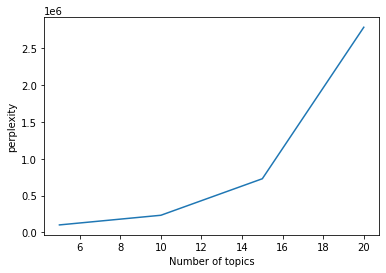

In [36]:
plt.plot([5, 10, 15, 20], np.exp(log_perplexity))
plt.xlabel("Number of topics")
plt.ylabel("perplexity")

We will keep the number of topics to 10 as the perplexity of the model is still low while keeping the number of topics minimal.

In [37]:
num_topics = 10
max_iter = 10

lda = LDA(k=num_topics, maxIter=max_iter, featuresCol= 'tf_idf_features')
lda_model = lda.fit(TFIDF_result)
lda_result = lda_model.transform(TFIDF_result)

In [38]:
num_top_words = 10

vocab = TF_mod.vocabulary # get vocabulary from the term frequency model

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]
       
udf_to_words = udf(get_words, ArrayType(StringType()))

topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=90)

+-----+------------------------------------------------------------------------------------------+
|topic|                                                                                topicWords|
+-----+------------------------------------------------------------------------------------------+
|    0|[public, public_health, health, tabletop_exercise, antiviral_drug, health_department, g...|
|    1|[chinese, apom, journal, chinese_journal, kong, hong, rs, bibliographic_database, publi...|
|    2|[patient, influenza, care, pandemic, hn, mortality, health, intensive_care, infection, ...|
|    3|[epidemic, distance, epiflex, metric, trace, reproduction_number, reproduction, road_di...|
|    4|              [peptide, cell, tumor, nsclc, target_phage, target, fusion, np, mouse, bind]|
|    5|[liver, pemfs, mesothelioma, pleural, hse, microtubule, bile, ecmo, reovirus, ecmo_trea...|
|    6|[exacerbation, exacerbation_severity, surfactant, pseudoknot, frameshifting, pseudoknot...|
|    7|[in

In [44]:
# # Data Visualization - 
# def format_data_pyldavis(clean_df, cvmodel, lda_trans,lda_model):
    
#     counts = clean_df.select((explode(clean_df.select("unigram"))).alias('tokens')).groupby('tokens').count()
    
#     wc = {i['tokens']:i['count'] for i in counts.collect()}
    
#     wc = [wc[x] for x in cvmodel.vocabulary]
    
#     data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T,
#            'doc_topic_dists': np.array([x.toArray() for x in lda_trans.select(['topicDistribution']).toPandas()['topicDistribution']]),
#            'doc_lengths': [x[0] for x in clean_df.select(size(clean_df.filtered)).collect()][:-1],
#            'vocab': cvmodel.vocabulary,
#            'term_frequency': wc}
#     return data

# data = format_data_pyldavis(lda_result, TF_mod, lda_result, lda_model)
# py_lda_data = pyLDAvis.prepare(**data)
# file_name = '/output/data-viz.html'
# pyLDAvis.display(py_lda_data)

## BERT Sentence Embeddings

In [55]:
documentAssembler = DocumentAssembler()\
                    .setInputCol('abstract')\
                    .setOutputCol('document')

In [57]:
doc_ass = documentAssembler.transform(lda_result)

In [49]:
bert = BertSentenceEmbeddings.pretrained() \
    .setInputCols("document") \
    .setOutputCol("bert_sentence_embeddings")

sent_small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]


In [58]:
bert_lda_df = bert.transform(doc_ass)

## Recommend Similar Papers
We are going to use the topic distributiosn of each paper to find the ones that are most similar through cosine similarity between the distributions.

In [62]:
# randomly sample. This will be replaced by a search methodology by researchers
random_sample = bert_lda_df.sample(False, 0.1, seed=42)

In [64]:
static_vector_topic = random_sample.select("topicDistribution").limit(1).collect()[0][0]
static_vector_embedding = random_sample.select('bert_sentence_embeddings').limit(1).collect()[0][0][0][5]

In [65]:
random_sample.select("title").first()[0]

'The 21st International Symposium on Intensive Care and Emergency Medicine, Brussels, Belgium, 20-23 March 2001'

In [67]:
def cos_sim(a,b):
    return float(np.dot(a,b)/ (np.linalg.norm(a) * np.linalg.norm(b)))

In [78]:
cos_df = bert_lda_df\
    .withColumn("coSim_topic", udf(cos_sim, FloatType())(col('topicDistribution'),\
                                                   array([lit(v) for v in static_vector_topic])))

cos_df = cos_df\
    .withColumn("coSim_bert", udf(cos_sim, FloatType())(col('bert_sentence_embeddings'),\
                                                   array([lit(v) for v in static_vector_embedding])))

In [79]:
cos_df= cos_df.withColumn("coSim_sum", col("coSim_topic")+col("coSim_bert"))

In [80]:
cos_df.columns

['cord_uid',
 'sha',
 'source_x',
 'title',
 'doi',
 'pmcid',
 'pubmed_id',
 'license',
 'abstract',
 'publish_time',
 'authors',
 'journal',
 'mag_id',
 'who_covidence_id',
 'arxiv_id',
 'pdf_json_files',
 'pmc_json_files',
 'url',
 's2_id',
 'lang',
 'finished_unigrams',
 'finished_ngrams',
 'finished_pos',
 'finished_pos_ngrams',
 'filtered_unigrams',
 'filtered_ngrams',
 'final',
 'tf_features',
 'tf_idf_features',
 'topicDistribution',
 'document',
 'bert_sentence_embeddings',
 'coSim_topic',
 'coSim_bert',
 'coSim_sum']

In [86]:
res_df = cos_df.sort(col("coSim_sum").desc())\
                .select(['doi',"title","url","coSim_topic","coSim_bert","coSim_sum"])\
                .limit(5)

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:37017)

In [116]:
fin_df

,Paper_ID,title,coSim
0,ae776b55c05bace11b708b29f9281dfc4a98ee4a,Journal Pre-proof The Impact of COVID-19 As A ...,NaN
1,49999396cb9c02d2ec5edb7ef6d4795f3aa850bc,Journal Pre-proof Ecological fallacy in COVID-...,NaN
2,c5ad3dcba3f39d885de5204d80dddf34e75845c0,"Journal Pre-proof A phase 2, open label, multi...",NaN
3,d3b433d903791c682135be571dbdf7835fe56741,"The impact of sex, gender and pregnancy on 200...",1.000000
4,e1e00ef1b70e15de6c0f747907de0089a49114cb,Inhaled anti-infective chemotherapy for respir...,0.971152
5,003218fcd130c4115f9775d3e4412b1c8a1215aa,Antibody seroconversion in asymptomatic and sy...,0.939856
6,5f539f363bd2dfc53c79612f60a8a77cab9402dd,Journal Pre-proof SARS-CoV-2-related mortality...,0.937925
7,8a6f529c068f4496811ff60cf1cb9e8783e3b5db,Abdominal gastrointestinal imaging findings on...,0.937702
8,8cb3c7f7716217bd54a97f220f73dc07ef1220c4,Machine Learning the Phenomenology of COVID-19...,0.913783
9,3d581f72704ea37fa3dc0368f20352cb88ece82f,Article Commentary Role of birth companion in ...,0.913742


In [79]:
df.sort(col("coSim").desc()).limit(10).select("abstract")

DataFrame[abstract: string]

## Text Preprocessing
Below are the text preprocessing functions we are using. 

In [10]:
def clean_sentence(sen):
    '''
    sen: sentence/document to be cleaned
    returns: cleaned sentence
    '''
    clean = [word for word in sen.split(' ') if word.isalnum()] # keep alpha numeric
    clean = [word.lower() for word in clean] # lower sentence text
    clean = [word for word in clean if word not in stop_words] # removes stop words
    clean = [word for word in clean if len(word)>=4] # removes words with length < 4
    
    return clean

def clean_up(document):
    '''
    document: takes in the cleaned sentence from the clean sentence and joins them
    returns: a "clean" document. 
    '''
    
    clean = [clean_sentence(a) for a in document]
    joined = [' '.join(a) for a in clean]
    
    return joined

def topic_render(topic,vocab,wordNum):
    '''
    topic: the topic we are looking at
    vocab: the vocabulary of the corpus
    wordNum: the number of words in a topic for each Vocab
    '''
    
    terms = topic[1]
    result = []
    for i in range(wordNum):
        term = vocab[terms[i]]
        result.append(term)
    return result

In [11]:
## main

N = 1000 # number of documents you want to work with. 
paper_path = "../input/CORD-19-research-challenge/document_parses/pdf_json"

start = time()
#json_files = read_json_files(root_path, spark, N)
#data = get_body_text(json_files, spark)
data = read_paper_data(paper_path, N)
print('Done data reading...')

#clean data - 
word_clean_F = F.udf(lambda x: clean_up(x), StringType())
data = data.withColumn('clean_body_text',word_clean_F('body'))
data = data.select('clean_body_text')
print('done cleaning data ...')

#tokenzing - 
tokenizer = Tokenizer(inputCol='clean_body_text',outputCol='tokenized_words')
token_df = tokenizer.transform(data).select('tokenized_words')
print('Tokenizing done ...')

# Stop word remover -
rem = StopWordsRemover(inputCol='tokenized_words',outputCol='filtered') # to ensure all stopwords are removed
clean_df = rem.transform(token_df).select('filtered')
print('Stop words removed ...')

# Count Vectorizer - 
cv = CountVectorizer(inputCol='filtered',outputCol='features')
cvmodel = cv.fit(clean_df)
count_df = cvmodel.transform(clean_df).select('features')
print('Done Count Vectorizer ..')

# TF-IDF -
tfidf = IDF(inputCol='features',outputCol='tf_features')
tfidfmodel = tfidf.fit(count_df)
tfidf_df = tfidfmodel.transform(count_df).select('tf_features')
print('Done TF-IDF')
end = time()

print('total preprocessing time: ',end-start,' seconds')

Done data reading...
done cleaning data ...
Tokenizing done ...
Stop words removed ...
Done Count Vectorizer ..
Done TF-IDF
total preprocessing time:  294.3796033859253  seconds


## Latent Dirichlet Allocation

In [12]:
##LDA model  
topics = 10
max_iter = 10

start = time()

lda = LDA(optimizer='em', k=topics, maxIter= max_iter)
lda_model = lda.fit(count_df)
lda_trans = lda_model.transform(count_df)

end = time()

print('LDA Complete')
print('total modeling time: ',end-start,' seconds')

LDA Complete
total modeling time:  391.12254548072815  seconds


In [30]:
lda_trans.select('topicDistribution').first()

Row(topicDistribution=DenseVector([0.0009, 0.0027, 0.0005, 0.0069, 0.9856, 0.0007, 0.0009, 0.0005, 0.0005, 0.0009]))

In [15]:
topicIndices

PythonRDD[339] at RDD at PythonRDD.scala:53

In [16]:
# terms per topic - 
topics = lda_model.topicsMatrix()
vocabArray = cvmodel.vocabulary
wordnum = 20
topicIndices = lda_model.describeTopics(maxTermsPerTopic=wordnum).rdd.map(tuple)
topic_final = topicIndices.map(lambda topic: topic_render(topic,vocabArray,wordnum)).collect()
for topic in range(len(topic_final)):
    print('Topic '+str(topic)+':')
    print(topic_final[topic])

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 335.0 failed 1 times, most recent failure: Lost task 0.0 in stage 335.0 (TID 2672) (b52c0c5e5a4a executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-10a3a2fe3829>", line 6, in <lambda>
  File "<ipython-input-10-f0379d160fe9>", line 34, in topic_render
IndexError: list index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-10a3a2fe3829>", line 6, in <lambda>
  File "<ipython-input-10-f0379d160fe9>", line 34, in topic_render
IndexError: list index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [17]:
# Data Visualization - 
def format_data_pyldavis(clean_df,cvmodel,lda_trans,lda_model):
    
    counts = clean_df.select((explode(clean_df.filtered)).alias('tokens')).groupby('tokens').count()
    
    wc = {i['tokens']:i['count'] for i in counts.collect()}
    
    wc = [wc[x] for x in cvmodel.vocabulary]
    
    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T,
           'doc_topic_dists': np.array([x.toArray() for x in lda_trans.select(['topicDistribution']).toPandas()['topicDistribution']]),
           'doc_lengths': [x[0] for x in clean_df.select(size(clean_df.filtered)).collect()][:-1],
           'vocab': cvmodel.vocabulary,
           'term_frequency': wc}
    return data

data = format_data_pyldavis(clean_df,cvmodel,lda_trans,lda_model)
py_lda_data = pyLDAvis.prepare(**data)
file_name = '/output/data-viz.html'
pyLDAvis.display(py_lda_data)

ValidationError: 
 * Length of doc_lengths not equal to the number of rows in doc_topic_dists;both should be equal to the number of documents in the data.

In [22]:
data['doc_topic_dists']

array([[0.09353419, 0.10238294, 0.10021335, ..., 0.08721742, 0.10384926,
        0.10203226],
       [0.09944791, 0.10024082, 0.10005861, ..., 0.09885403, 0.1003377 ,
        0.10019124],
       [0.09960017, 0.1001783 , 0.10004579, ..., 0.09918371, 0.10024212,
        0.10013619],
       ...,
       [0.10045108, 0.09982114, 0.09996518, ..., 0.10105516, 0.09970343,
        0.09982186],
       [0.1004689 , 0.09980995, 0.09996039, ..., 0.10107858, 0.09969482,
        0.09981826],
       [0.1004575 , 0.09980776, 0.09995569, ..., 0.10101719, 0.0997082 ,
        0.09982934]])

In [ ]:
pyLDAvis.save_html(py_lda_data,'viz.html')

In [ ]:
FileLink(r'viz.html')